## Optimal Stopping Problems, Computational Appendix

> Presented by [Arnav Sood](email:arnav.sood@ubc.ca) and [Jesse Perla](email:jesseperla@gmail.com)

This notebook is a computational appendix to the [earlier notebook](../generated/LCP_simple.html) on optimal stopping problems, and their formulations as linear complementarity problems (LCPs).

#### Model Setup

As before, we run some setup code

In [1]:
# install if required,
# ] add SimpleDifferentialOperators Plots Suppressor BenchmarkTools

using SimpleDifferentialOperators, Plots, LinearAlgebra, Suppressor, BenchmarkTools

And define a set of model objects

In [2]:
μ = -0.1
σ = 0.1
ρ = 0.05
γ = 0.5
ρ = 0.05
S₀ = 20.0
u(x) = x^γ  # (13)
S(x) = S₀  # (15)
@assert μ <= 0 # otherwise we need to swap the L₁₋ operator

We can also define the boundary conditions and LCP matrices at this stage

In [3]:
M = 300
x = range(0.0, 5.0, length = M)
bc = (Reflecting(), Reflecting())  # assume x_t reflects at 0.0 and 5.0
L = I * ρ - μ*L₁₋(x, bc) - σ^2 / 2 * L₂(x, bc)  # (2) and (14)

q = -u.(x) + L*S.(x)  # (9)
w(z) = L*z + q; # (10)

#### PATHSolver

This is the first solver we tried. To install it, simply run

In [4]:
# install if required
# ] add PATHSolver

And to use it

In [5]:
using PATHSolver

lb = zeros(M)
ub = 300*ones(M) # Need to have upper bounds for the z.
code, z, w_val = @btime @suppress solveLCP($w, $lb, $ub)  # Solves (12)
@assert code == :Solved  # otherwise, an error in convergence

  3.923 ms (426 allocations: 2.45 MiB)


We can also try the MCP solver. We expect this to be slower, since we forgo specializations for the linear case.

In [6]:
code_, z_, w_val_ = @btime @suppress solveMCP($w, $lb, $ub)  # Solves (12)
@assert code_ == :Solved  # otherwise, an error in convergence

  13.934 ms (2014 allocations: 33.56 MiB)


As a sanity check, we can plot

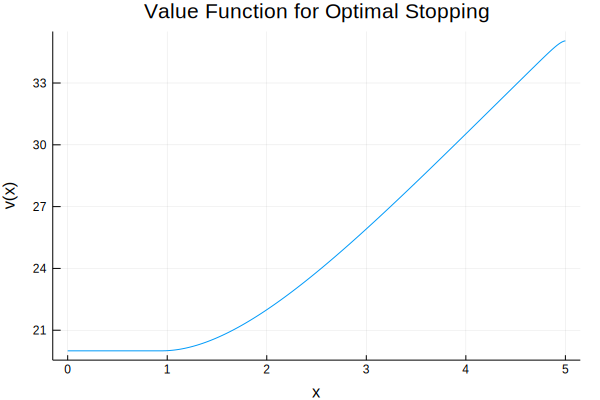

In [7]:
v = z + S.(x)
plot(x, v, title = "Value Function for Optimal Stopping",
     legend = false, ylabel = "v(x)", xlabel = "x")

**Note:** As mentioned, for anything other than a rough estimate, the Julia code you're benchmarking should be inside of a function.

#### NLsolve

There is also the [NLsolve.jl](https://github.com/JuliaNLSolvers/NLsolve.jl) package, which offers a `mcpsolve()` method for mixed complementarity problems.

In [8]:
# install if required
# ] add NLsolve

And run

In [9]:
using NLsolve

r = @btime @suppress mcpsolve($w, $lb, $ub,
                zeros(300), # initial condition
                reformulation = :smooth, # uses a so-called "Fischer function" to smooth out the problem
                autodiff = :forward,
                inplace = false,
                ftol = 1e-12);

@assert converged(r) == true # otherwise, an error in convergence

  72.944 ms (9167 allocations: 49.02 MiB)


And the plot

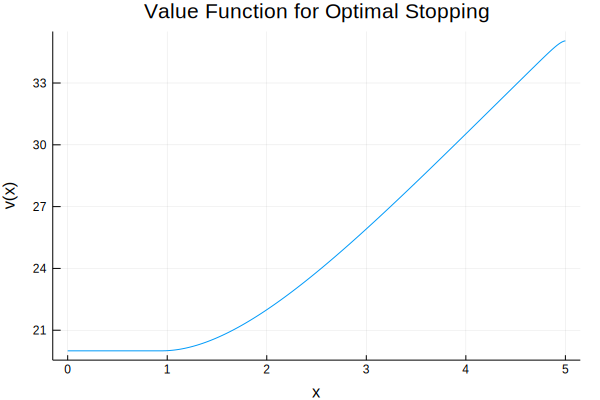

In [10]:
v = r.zero + S.(x)
plot(x, v, title = "Value Function for Optimal Stopping",
     legend = false, ylabel = "v(x)", xlabel = "x")

#### JuMP (Ipopt)

We can also use [JuMP](https://github.com/JuliaOpt/JuMP.jl), Julia's DSL for numerical programming.

The solver is the [Interior Point OPTimizer (IPOPT)](https://en.wikipedia.org/wiki/IPOPT).

In [11]:
# install if required
# ] add JuMP Ipopt

The setup here is a bit different, since we're using the [quadratic formulation](https://en.wikipedia.org/wiki/Linear_complementarity_problem#Convex_quadratic-minimization:_Minimum_conditions).

In [12]:
using JuMP, Ipopt

m = Model(with_optimizer(Ipopt.Optimizer, tol=1e-12));
@variable(m, z[1:300]);
@constraint(m, z .>= 0);
@constraint(m, L*z + q .>= 0);
@objective(m, Min, z'*L*z + z'*q);
@suppress optimize!(m);

termination_status(m)

LOCALLY_SOLVED::TerminationStatusCode = 4

And the plot

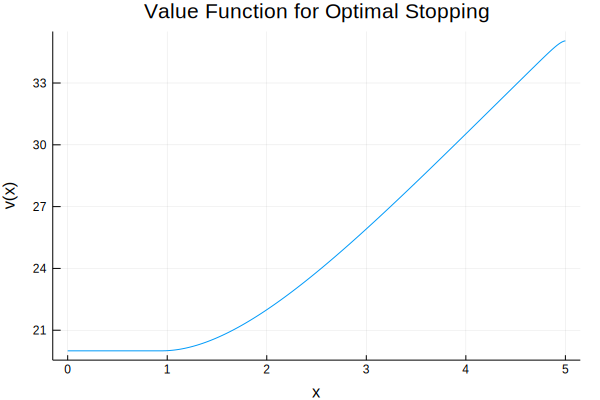

In [13]:
v = value.(z) + S.(x)
plot(x, v, title = "Value Function for Optimal Stopping",
     legend = false, ylabel = "v(x)", xlabel = "x")

Note that we didn't compute a benchmark. As `optimize!()` is in-place (that is, it modifies its arguments), we need to ensure that runs are actually independent.

Here's one approach.

In [14]:
function ipoptFunc()
  m = Model(with_optimizer(Ipopt.Optimizer, tol=1e-12));
  @variable(m, z[1:300]);
  @constraint(m, z .>= 0);
  @constraint(m, L*z + q .>= 0);
  @objective(m, Min, z'*L*z + z'*q);
  @suppress optimize!(m);
end

@benchmark ipoptFunc()

BenchmarkTools.Trial: 
  memory estimate:  4.62 MiB
  allocs estimate:  71792
  --------------
  minimum time:     96.496 ms (0.00% GC)
  median time:      99.688 ms (0.00% GC)
  mean time:        101.147 ms (0.98% GC)
  maximum time:     112.563 ms (4.37% GC)
  --------------
  samples:          50
  evals/sample:     1

In other words, we're benchmarking the process of building and solving a model from scratch.

Note that if you want more granular performance data, you can use the `@benchmark` macro as above. 

#### JuMP (OSQP)

The flexibility of JuMP is that, after formulating the problem, swapping out solvers is fairly trivial.

Here's the same code, using the Oxford [OSQP](https://osqp.org/) solver (Operator Splitting for Quadratic Programs).

As you can see, only one line needed to change.

In [15]:
# install if required
# ] add OSQP

And run

In [16]:
using OSQP

m = Model(with_optimizer(OSQP.MathOptInterfaceOSQP.Optimizer))
@variable(m, z[1:300]);
@constraint(m, z .>= 0);
@constraint(m, L*z + q .>= 0);
@objective(m, Min, z'*L*z + z'*q);
@suppress optimize!(m);

@show termination_status(m)

termination_status(m) = ALMOST_OPTIMAL::TerminationStatusCode = 7


ALMOST_OPTIMAL::TerminationStatusCode = 7

And the plot

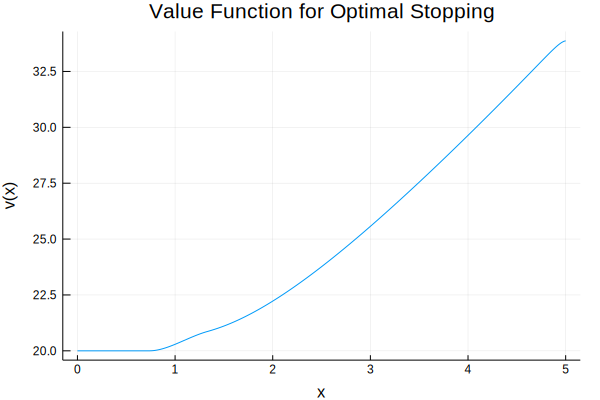

In [17]:
v = value.(z) + S.(x)
plot(x, v, title = "Value Function for Optimal Stopping",
     legend = false, ylabel = "v(x)", xlabel = "x")

We can also write benchmarking code as above

In [18]:
function osqpFunc()
  m = Model(with_optimizer(OSQP.MathOptInterfaceOSQP.Optimizer))
  @variable(m, z[1:300]);
  @constraint(m, z .>= 0);
  @constraint(m, L*z + q .>= 0);
  @objective(m, Min, z'*L*z + z'*q);
  @suppress optimize!(m);
end

@benchmark osqpFunc()

BenchmarkTools.Trial: 
  memory estimate:  5.15 MiB
  allocs estimate:  75630
  --------------
  minimum time:     43.082 ms (0.00% GC)
  median time:      45.406 ms (0.00% GC)
  mean time:        46.145 ms (2.21% GC)
  maximum time:     52.118 ms (0.00% GC)
  --------------
  samples:          109
  evals/sample:     1

#### Conclusions 

The outcomes of this notebook are: 

* Expository code for solving an LCP-formulated stopping problem using a variety of Julia tools.

* The finding that using code optimized for the linear case leads to noticeable speed gains, and that `PATHSolver.jl` is a good bet for small problems like this one. 

* Note: The size is crucial for this kind of analysis. `JuMP` (for example) is designed with massive problems in mind, and as such might be doing work that's costly here, but vital for the larger case.